In [18]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import spock
from spock import FeatureClassifier
import corner
from tqdm import tqdm
from scipy import stats
from celmech import Andoyer
from statsmodels.stats.weightstats import DescrStatsW
import warnings
import rebound
import timeit
import sys
from multiprocessing import Pool
from p_tqdm import p_map
from multiprocessing import Pool
warnings.simplefilter(action='ignore', category=FutureWarning)

In [12]:
# last TESS observation:
t_tess = 4664.65

# last K2 observation:
t_K2 = 2265

t = t_tess - t_K2

t_orbits = t/8.24958

t_orb = t_orbits*5.98
tmax = 1.0*t_orb
Nout = 200

t = np.linspace(0,tmax,Nout)
obs_tess = np.where(np.round(abs(t - t_orb),6) == np.round(np.min(abs(t - t_orb)),6))[0][0]
delta_index = 0
obs_idx=[delta_index,obs_tess+delta_index]

nobs = 2
obs_err = np.array([0.0001, 0.0005])
obs = np.array([1.503, 1.503])

def makesim(theta):


    e_forced, e_free, mu, deltaT, mb, eb, pomegab, thetab = theta

    mratio=0.5
    e_com = 0.0
    phiecom=float(np.random.uniform(0, 2*np.pi, size=1)) # varying between 0 and 2pi
    theta1 = np.pi
    Mstar = 1.1
    m1 = mratio*10**mu
    m2 = (1-mratio)*10**mu
    phi = np.pi # where equilibrium is
    theta1 = np.pi # position of planet b

    andvars = Andoyer.from_Z(j=3, k=1, Z=(e_forced+e_free)/np.sqrt(2), phi=phi,
                             Zstar=e_forced/np.sqrt(2), Mstar=Mstar, m1=m1, m2=m2,
                             Zcom=e_com/np.sqrt(2), phiZcom=phiecom, theta1=theta1)

    try:

        sim = andvars.to_Simulation()
        sim.add(m=mb, P=sim.particles[2].P*1.946, e=eb, pomega=pomegab, theta=thetab)
        sim.integrator="whfast"
        sim.dt = sim.particles[1].P/20
        sim.ri_whfast.safe_mode = 0
        sim.integrate(deltaT)
        sim.t = 0
        return sim
    except:
        print(e_forced, e_free, deltaT, mu)
        raise

def run(sim):

    Pratios = np.zeros(Nout)
    ps = sim.particles

    for i, time in enumerate(t):

        sim.integrate(time)
        Pratios[i] = ps[2].P/ps[1].P

    return Pratios

def compute_model(theta):

    #if theta.ndim > 1:
    #    sims = [makesim(param) for param in theta]
#
    #    period_ratios = [run(sim) for sim in sims]
#
#
#
    #    return [periods[obs_idx] for periods in period_ratios]
    
    #else:
    sim = makesim(theta)
    period_ratios = run(sim)
    return period_ratios[obs_idx]

def gen_priors_array(seed):

    #size_arr = int(n)
    
    rng = np.random.default_rng(seed)

    eforced_0 = float(rng.uniform(0.0005,0.23,size=1)) # changing the upper limit to the crossing eccentricity
    efree_0 = float(rng.uniform(0.0005,0.003,size=1)) # changing the bounds because experiments show that
    mu_0 = float(rng.uniform(np.log10(8.964e-6), np.log10(5.25e-4), size=1)) # new upper limit of 0.55 Mjup by Mascareno

    #mb_0 = stats.norm.rvs(loc=0.69, scale=0.19, size=size_arr)*9.54e-4
    mb_0 = float(stats.truncnorm.rvs(a=(0 - 0.69)/0.19, b = np.inf, loc=0.69, scale=0.19, size=1))
    #eb_0 = stats.norm.rvs(loc=0.13, scale=0.07, size=size_arr)
    eb_0 = float(stats.truncnorm.rvs(a = (0 - 0.13)/0.07, b = np.inf, loc=0.13, scale=0.07, size=1))
    pomegab_0 = float(np.random.uniform(0, 2*np.pi, size=1))

    thetab_0 = float(np.random.uniform(0, 2*np.pi, size=1))

    deltaT_0 = float(rng.uniform(0, 2000, size=1))

    #prior_set = np.column_stack((eforced_0, efree_0, mu_0, deltaT_0, mb_0, eb_0, pomegab_0, thetab_0))
    prior_set = (eforced_0, efree_0, mu_0, deltaT_0, mb_0, eb_0, pomegab_0, thetab_0)
    #valid_priors = []
    #for param in prior_set:
    #    if param[4] < 0 or param[5] < 0:
    #        continue
    #    else:
    #        valid_priors.append(param)

    return prior_set


In [13]:
def lnlike(theta):

    #e_forced, e_free, deltaT, mu, mb, eb, pomegab, thetab = theta

    model = compute_model(theta)
    argument = (obs - model)**2 / obs_err**2
    #if theta.ndim > 1:
    #    loglike = [0.5*np.sum(arg) for arg in argument]
    #else: 
    loglike = 0.5*np.sum(argument)
    return loglike

def get_posteriors(seed):
    
    priors = gen_priors_array(seed)
    like_val = lnlike(priors)

    rng = np.random.default_rng(seed)

    prob = np.log10(np.random.random())
    
    
    if -like_val > prob:
        post = prior

        return post

    else:
    	return np.nan

In [14]:
seeds = list(range(0, 1000))
prior_test = np.array([gen_priors_array(seed) for seed in seeds])

In [15]:
likes = [lnlike(prior) for prior in tqdm(prior_test)]
np.min(likes)


 22%|██▏       | 221/1000 [00:04<00:15, 51.29it/s]/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/rebound/simulation.py:712: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)

 88%|████████▊ | 878/1000 [00:16<00:02, 51.56it/s]


100%|██████████| 1000/1000 [00:19<00:00, 51.19it/s][A


92433.12935419603

In [17]:
if __name__ == '__main__':
    pool = Pool(processes=3)
    results = pool.map(lnlike, prior_test)
    pool.close()
    pool.join()
    print(results)

KeyboardInterrupt: 

In [6]:
#start_time = timeit.default_timer()
post_test = np.array([get_posteriors(seeds) for seed in tqdm(seeds)])
print(len(post_test))
print(len(post_test[~np.isnan(post_test)]))
#print('Elapsed time:',timeit.default_timer() - start_time)

  0%|          | 12/10000 [00:00<10:36, 15.70it/s]/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/rebound/simulation.py:712: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)
100%|██████████| 10000/10000 [10:48<00:00, 15.42it/s]

10000
0


In [7]:
start_time = timeit.default_timer()
post_test = np.array(get_posteriors(0, 1e5))
#res = post_test[~np.isnan(post_test)]
print(len(post_test))
print('Elapsed time:',timeit.default_timer() - start_time)

96891
Elapsed time: 1412.801735845


In [8]:
res = post_test[~np.isnan(post_test)]
res

array([], dtype=float64)

In [159]:
mbs = [prior[4] for prior in prior_test]
ebs = [prior[5] for prior in prior_test]

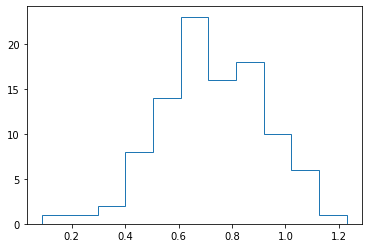

In [160]:
%matplotlib inline
plt.hist(np.array(mbs), bins='auto',histtype='step')
plt.show()

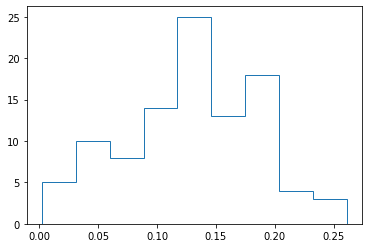

In [161]:
plt.hist(np.array(ebs), bins='auto', histtype='step')
plt.show()

In [35]:
0.64+3*0.19

1.21

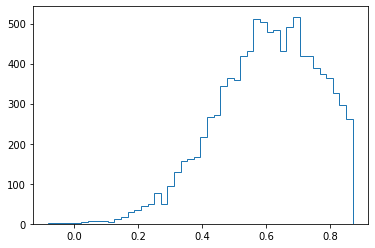

In [124]:

a, b = (0 - 1) / 0.5, (1.2 - 1) / 0.5
test = stats.truncnorm.rvs(a=-5, b=1.21, loc=0.64, scale=0.19, size=10000)
plt.hist(test, bins='auto', histtype='step')
plt.show()

-2.0

In [19]:
#Define a worker — a function which will be executed in parallel
def worker(x):
    return x*x
if __name__ ==  '__main__': 
 num_processors = 3
 p=Pool(processes = num_processors)
 output = p.map(workers.worker,[i for i in range(0,3)])
 print(output)

KeyboardInterrupt: 